# Initial State / Ensemble Tests

The plan is to prepare some initial density matrix $\hat{\rho}_0$ which we will take from thermal DFT. Traditionally thermal (Mermin) DFT is formulated in the grand canonical ensemble (GCE), and one finds a density matrix which minimizes the grand potential $\Omega = U - TS -\mu N$, where $U=\langle H\rangle$, and $S = k_B \rho \log \rho$. In general the density matrix that minimizes $\Omega$ is the grand-canonical density matrix

$$ \hat{\rho} = \frac{1}{Z_\mathrm{GC}} \sum_{\eta=0}^{\infty} \sum_{I}^{N_I(\eta)} e^{-\beta (E_I(\eta)-\mu\eta)} |E_I(\eta)\rangle\langle E_I(\eta)| $$

where $E_I(\eta) (|E_I(\eta)\rangle)$ are eigensvalues (eigenstates) of the Hamiltonian $H$ in a given $\eta$-electron particle sector, and $Z_{\mathrm{GC}}$ is the partition function

Within KS-DFT the density matrix is found by minimizing the grand potential associated with a fictitious non-interacting system which yields the same density as our original interacting one (in the limit we know the exact (thermal) exchange correlation functional). One thing we can look at is the the density matrix constructed assuming a non-interacting Hamiltonian of the form

$$ H = \sum_i \varepsilon_i a_i^\dagger a_i, $$

then we can write the usual expression for the GCE associated with free electrons 

\begin{equation}
    \hat{\rho}_0 = \frac{1}{Z_\mathrm{GC}^0} \sum_{\eta=0}^{\infty} \sum_{\{n\}\vert_\eta} e^{-\beta (\sum_{i\in\{\eta\}}\varepsilon_i-\mu)} |\{n\}\rangle\langle\{n\}|,
\end{equation}

where $\varepsilon_i$ is a KS eigenvalue and the sum is over all possible occupations of $\eta$ orbitals within the (potentially infinitely-sized) basis.

This form of density matrix allows us to identify the usual Fermi factors which define our KS orbital occupations

$$ \langle \hat{n}_i\rangle = \frac{1}{e^{-\beta(\varepsilon_i-\mu)}+1} = f_i$$

and various thermodynamic relations can be simplified, like

$$ Z_{GC}^0 = \prod_i (1+e^{-\beta(\varepsilon_i-\mu)}) $$

etc.

Assuming the occupations from KS DFT are appropriate then the goal should be to prepare Eq. 1 from at least two different ways.

1. We can sample bit strings from Eq. 1 with probability proportional to the Boltzmann weight and then time evolve these states and finally average to obtain the appropriate expectation value.
2. We may be able to prepare a circuit which prepares the mean-field ensemble and then map this to first quantization. 

## Path 1. Question 1: How many samples are needed for a representive system 

In [15]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")

In [85]:
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr
volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz_radius
# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr


In [21]:
# We see rs ~ 1 meaning the system system is quite dense.
# Next let's check the temperature
# We have two temperatures 10eV and 1eV
from ase.units import kB # eV / K
print("10 eV = {} K".format(10/kB))
print("1 eV = {} K".format(1/kB))

10 eV = 116045.22060401007 K
1 eV = 11604.522060401008 K


In [30]:
from mec_sandia.ueg import calc_theta_from_beta
from ase.units import Hartree

# Next we can look at Theta = T / TF to see if we're in the warm dense regime
T_Ha = 10 / Hartree
beta = 1.0 / T_Ha
theta_10 = calc_theta_from_beta(beta, rs)
print("10 eV => Theta = {}".format(theta_10))
T_Ha = 1 / Hartree
beta = 1.0 / T_Ha
theta_1 = calc_theta_from_beta(beta, rs)
print("1 eV => Theta = {}".format(theta_1))
# We see that Theta is not negligeable => Warm dense regime.

10 eV => Theta = 0.17220781705309057
1 eV => Theta = 0.017220781705309055


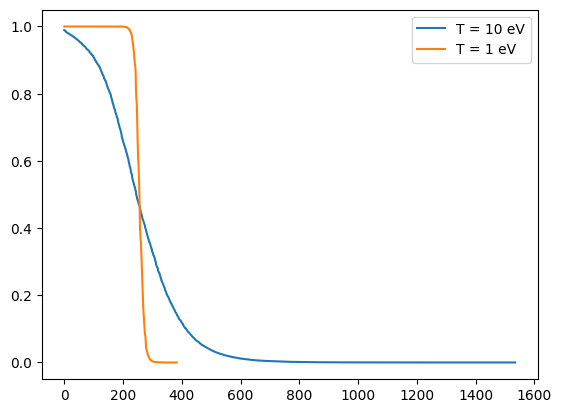

In [43]:
# Let's check the number of samples to converge say the occupancies to within x percent in the initial density matrix. 

from mec_sandia.vasp_utils import read_kohn_sham_data
import matplotlib.pyplot as plt

# 1. First read the KS data
eigs_10eV, occs_10eV = read_kohn_sham_data("../vasp_data/C_10eV_EIGENVAL")
eigs_1eV, occs_1eV = read_kohn_sham_data("../vasp_data/C_1eV_EIGENVAL")
plt.plot(occs_10eV, label="T = 10 eV", color="C0")
plt.plot(occs_1eV, label="T = 1 eV", color="C1")
plt.legend()

To get some sort of estimate at how many samples one may need we can look at the error in the occupations introduced by sampling and also in one-body properties. Although the latter isn't necessarily what we want to compute (we just want the kinetic energy of one particle, not all of them), it could be informative.

### $T = 10$ eV

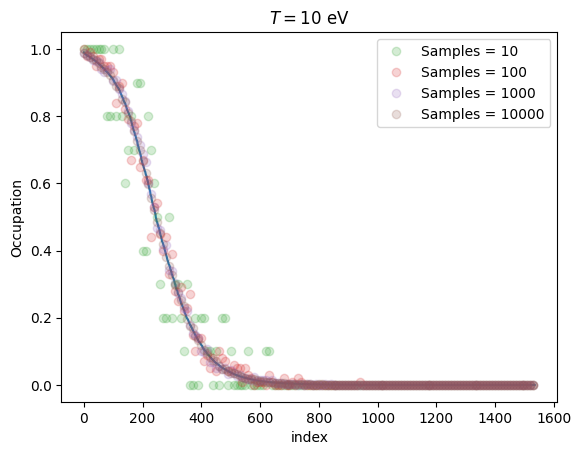

In [88]:
# Now let's see how sampling compares
# The Density matrix class produces the desired sum over Slater determinants appropriately weighted.
# It's overkill to store the bitstrings but may be helpful later.
from mec_sandia.density_matrix import DensityMatrix
np.random.seed(7)
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    occs, errs = dm_10eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], occ_a[::10], yerr=err_a[::10], lw=0, alpha=0.2, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.title("$T=10$ eV")
plt.xlabel("index")
plt.ylabel("Occupation")
plt.plot(occs_10eV, label="KS-DFT", color="C0")

Text(0.5, 1.0, '$T=10$ eV')

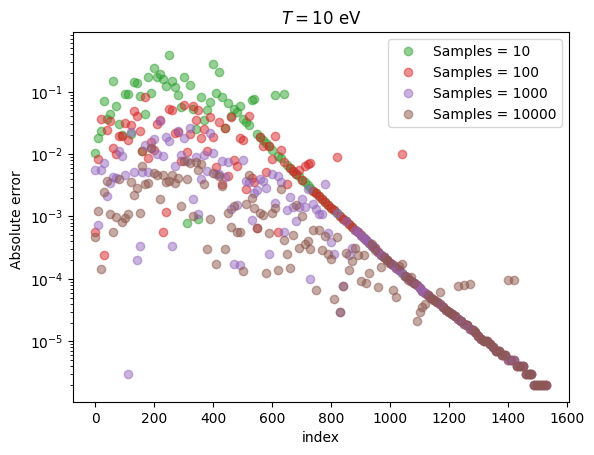

In [75]:

from mec_sandia.density_matrix import DensityMatrix
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    occs, errs = dm_10eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], np.abs((occ_a[::10]-occs_10eV[::10])), yerr=err_a[::10], lw=0, alpha=0.5, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.ylabel("Absolute error ")
plt.yscale("log")
plt.xlabel("index")
plt.title("$T=10$ eV")

Text(0.5, 1.0, '$T=10$ eV')

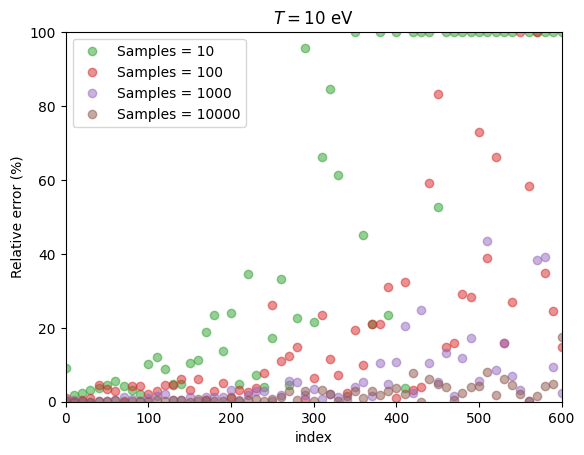

In [80]:
from mec_sandia.density_matrix import DensityMatrix
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    occs, errs = dm_10eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], 100*np.abs((occ_a[::10]-occs_10eV[::10]))/occs_10eV[::10], yerr=err_a[::10]/occs_10eV[::10], lw=0, alpha=0.5, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.ylabel("Relative error (%)")
plt.ylim([0, 100])
plt.xlim([0, 600])
plt.xlabel("index")
plt.title("$T=10$ eV")

Text(0.5, 1.0, '$T$ = 10eV')

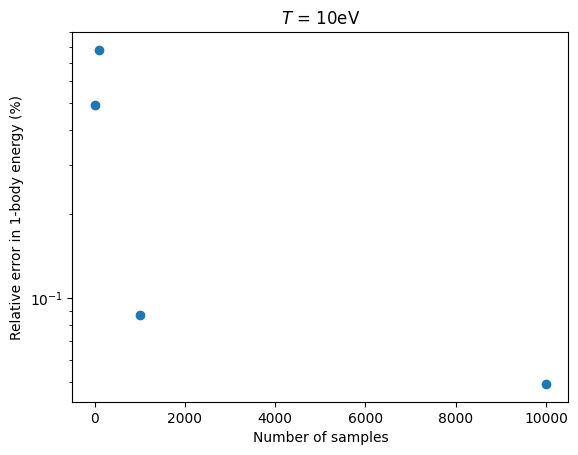

In [79]:
# Look at error in "one-body energy" = \sum_i e_i f_i (this isn't anything physical because of double counting but could be useful proxy)
from mec_sandia.density_matrix import DensityMatrix
one_body = []
one_body_err = []
samples = [10, 100, 1000, 10000]
for isamp, num_samples in enumerate(samples): 
    dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
    e1b, err = dm_10eV.contract_diagonal_one_body(eigs_10eV)
    one_body.append(e1b)
    one_body_err.append(err)

e1b_ref = 2 * np.einsum("i,i->", occs_10eV, eigs_10eV)
plt.errorbar(samples, 100*abs(e1b_ref-one_body)/e1b_ref, yerr=one_body_err/e1b_ref, fmt="o")
plt.yscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Relative error in 1-body energy (%)")
plt.title("$T$ = 10eV")


### $T = 1$ eV

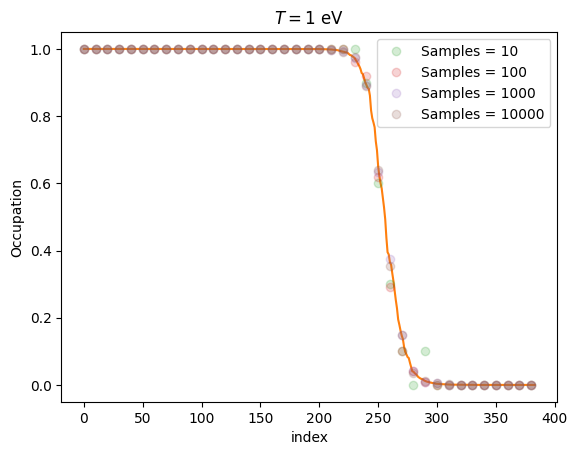

In [89]:
from mec_sandia.density_matrix import DensityMatrix
np.random.seed(7)
for isamp, num_samples in enumerate([10, 100, 1000, 10000]): 
    dm_1eV = DensityMatrix.build_grand_canonical(occs_1eV, num_samples)
    occs, errs = dm_1eV.compute_occupations()
    occ_a, err_a = occs[::2], errs[::2]
    ixs = np.arange(len(occ_a))
    plt.errorbar(ixs[::10], occ_a[::10], yerr=err_a[::10], lw=0, alpha=0.2, marker="o", color=f"C{isamp+2}", label=f"Samples = {num_samples}")
plt.legend()
plt.title("$T=1$ eV")
plt.xlabel("index")
plt.ylabel("Occupation")
plt.plot(occs_1eV, label="KS-DFT", color="C1")

Text(0.5, 1.0, '$T$ = 1eV')

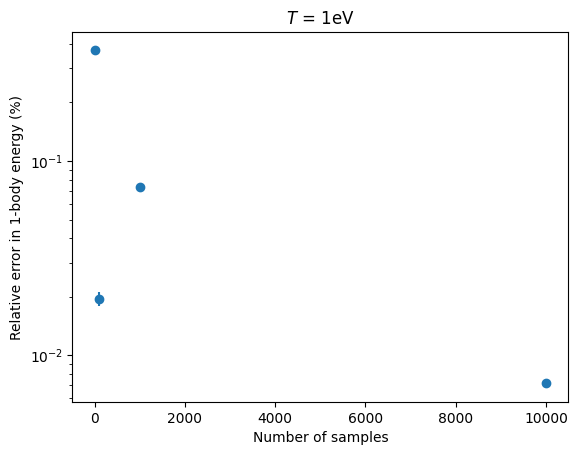

In [84]:
# Look at error in "one-body energy"
from mec_sandia.density_matrix import DensityMatrix
one_body = []
one_body_err = []
samples = [10, 100, 1000, 10000]
for isamp, num_samples in enumerate(samples): 
    dm_1eV = DensityMatrix.build_grand_canonical(occs_1eV, num_samples)
    e1b, err = dm_1eV.contract_diagonal_one_body(eigs_1eV)
    one_body.append(e1b)
    one_body_err.append(err)

e1b_ref = 2 * np.einsum("i,i->", occs_1eV, eigs_1eV)
plt.errorbar(samples, 100*abs(e1b_ref-one_body)/e1b_ref, yerr=one_body_err/e1b_ref, fmt="o")
plt.yscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Relative error in 1-body energy (%)")
plt.title("$T$ = 1eV")

## Path 1. Question 2: How large are Ensemble Effects?

For a finite system that we can simulate one might fear that the GCE might differ significantly from a canonical ensemble (CE) depiction of the system, with the latter being potentially more appropriate. We can estimate the ensemble effects by rejection sampling to produce the canonical ensemble density matrix

\begin{equation}
    \hat{\rho}_0 = \frac{1}{Z_\mathrm{CE}^0} \sum_{\{n\}\vert_{\eta=\bar{\eta}}} e^{-\beta (\sum_{i\in\{\eta\}}\varepsilon_i-\mu)} |\{n\}\rangle\langle\{n\}|
\end{equation}

where $\bar{\eta}$ is the desired number of electrons (i.e. that specified by our input atoms and charge.). Note that the chemical potential factor cancels in expectation values as it's a common constant factor in the numerator and denominator.

Also note this isn't exactly the ensemble that minimizes the CE-KS-DFT equations as the eigenvalues were determined in the GCE. The theoretically consistent thing to do would be solve DFT problem by minimizing the Helmholtz free energy $F = U - TS$ which would yield a density matrix like Eq. 2 above, but with slightly different occupations. Again we expect these differences to disappear in the TDL (although this is sort of subtle for interacting systems). 

Regardless, it serves as a useful estimate.

Text(0.5, 0, 'number of electrons')

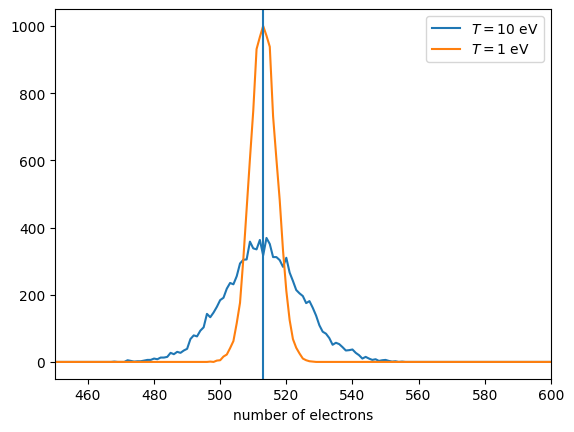

In [106]:
# First let's look at the distribution of N values in our GCE density matrix
from mec_sandia.density_matrix import DensityMatrix
num_samples = 10000
dm_10eV = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
binned_data = dm_10eV.histogram_electron_counts()
plt.plot(binned_data, label="$T = $10 eV", color="C0")
dm_1eV = DensityMatrix.build_grand_canonical(occs_1eV, num_samples)
binned_data = dm_1eV.histogram_electron_counts()
plt.plot(binned_data, label="$T = $1 eV", color="C1")
plt.xlim([450, 600])
plt.axvline(num_elec)
plt.legend()
plt.xlabel("number of electrons")

We see the variance grows with temperature as expected.

### Ensemble Check 1: Occupation numbers

1B(GCE) = 11225.445462795766 +/- 2.2545506741052845
1B(CE) = 11227.602162053567 +/- 4.747506452897524
Error = -2.1566992578009376
Relative Error = 0.019208903438795073 %


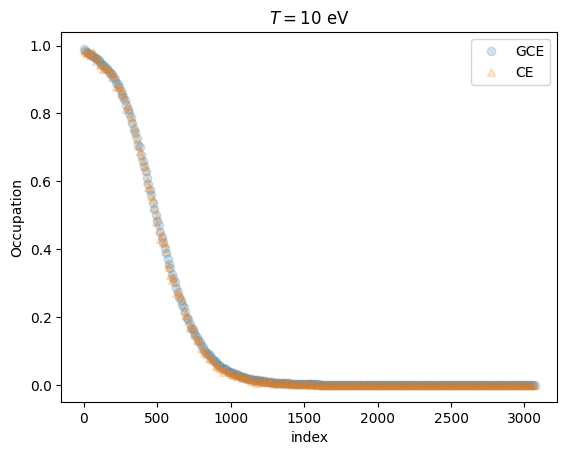

In [112]:
from mec_sandia.density_matrix import DensityMatrix
np.random.seed(7)
num_samples = 50000
dm_10eV_gce = DensityMatrix.build_grand_canonical(occs_10eV, num_samples)
dm_10eV_ce = DensityMatrix.build_canonical(occs_10eV, num_samples, num_elec)
occs_gce, errs_gce = dm_10eV_gce.compute_occupations()
occs_ce, errs_ce = dm_10eV_ce.compute_occupations()
indx = np.arange(len(occs_gce))[::10]
plt.errorbar(indx, occs_gce[::10], yerr=errs_gce[::10], lw=0, alpha=0.2, marker="o", color=f"C0", label=f"GCE")
plt.errorbar(indx, occs_ce[::10], yerr=errs_ce[::10], lw=0, alpha=0.2, marker="^", color=f"C1", label=f"CE")
plt.legend()
plt.title("$T=10$ eV")
plt.xlabel("index")
plt.ylabel("Occupation")
e1b_gce, err_gce = dm_10eV_gce.contract_diagonal_one_body(eigs_10eV)
e1b_ce, err_ce = dm_10eV_ce.contract_diagonal_one_body(eigs_10eV)
print("1B(GCE) = {} +/- {}".format(e1b_gce, err_gce))
print("1B(CE) = {} +/- {}".format(e1b_ce, err_ce))
print("Error = {}".format(e1b_gce-e1b_ce))
print("Relative Error = {} %".format(100*abs(e1b_gce-e1b_ce)/(e1b_ce)))

1B(GCE) = 9050.284881923482 +/- 0.6664074486774775
1B(CE) = 9050.2845922111 +/- 0.10178815370493119
Error = 0.00028971238316444214
Relative Error = 3.201141137746937e-06 %


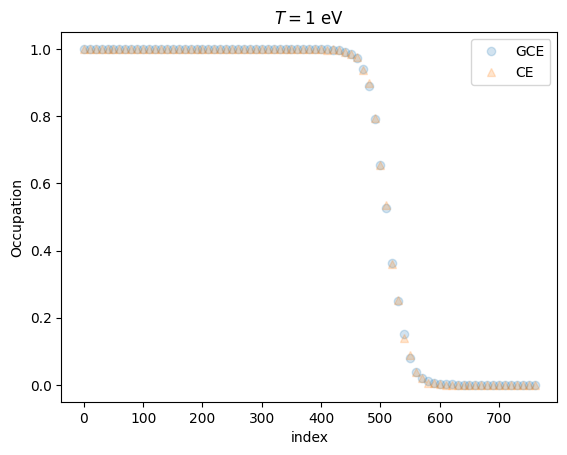

In [113]:
np.random.seed(7)
num_samples = 50000
dm_1eV_gce = DensityMatrix.build_grand_canonical(occs_1eV, num_samples)
dm_1eV_ce = DensityMatrix.build_canonical(occs_1eV, num_samples, num_elec)
occs_gce, errs_gce = dm_1eV_gce.compute_occupations()
occs_ce, errs_ce = dm_1eV_ce.compute_occupations()
indx = np.arange(len(occs_gce))[::10]
plt.errorbar(indx, occs_gce[::10], yerr=errs_gce[::10], lw=0, alpha=0.2, marker="o", color=f"C0", label=f"GCE")
plt.errorbar(indx, occs_ce[::10], yerr=errs_ce[::10], lw=0, alpha=0.2, marker="^", color=f"C1", label=f"CE")
plt.legend()
plt.title("$T=1$ eV")
plt.xlabel("index")
plt.ylabel("Occupation")
e1b_gce, err_gce = dm_1eV_gce.contract_diagonal_one_body(eigs_10eV)
e1b_ce, err_ce = dm_1eV_ce.contract_diagonal_one_body(eigs_10eV)
print("1B(GCE) = {} +/- {}".format(e1b_gce, err_gce))
print("1B(CE) = {} +/- {}".format(e1b_ce, err_ce))
print("Error = {}".format(e1b_gce-e1b_ce))
print("Relative Error = {} %".format(100*abs(e1b_gce-e1b_ce)/(e1b_ce)))

Conclusion : Looks like ensemble doesn't matter very much

## Path 2: Question 1: Can we discard states for fixed particle number simulation?

## Path 2: Question 2: How does the quantum circuit work?


TODO: Proof of concept cirq implementation?
